# SQL-based database

Defines an sqlite database, built from the json-based data dumps provided at 'https://github.com/adactio/TheSession-data'.

Tables are included for:

- Users
- Tunes
- Settings
- Aliases
- Recordings
- Recorded Tunes
- Events
- Sessions

Fields are added to the database from additional scraped directly from thesession.org, using the sites api, and from information consolidated by this codebase.

I plan to extend the database class with a variety of pythonic seach functions wrapping SQL queries for specific needs from other parts of the code.

In [1]:
from thesessionDB import thesessionDB

db = thesessionDB(delete=True,download=False)

db.defineTables()
#db.populateTablesFromJSON(Ntest=1000)
db.populateTablesFromJSON()

db.cur.execute('SELECT * FROM users LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Users:'
for x in q:
    print x

db.cur.execute('SELECT * FROM tunes LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Tunes:'
for x in q:
    print x

db.cur.execute('SELECT setting_id, tune_id, date, user FROM settings LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Settings:'
for x in q:
    print x

db.cur.execute('SELECT * FROM aliases LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Aliases:'
for x in q:
    print x

db.cur.execute('SELECT * FROM artists LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Artists:'
for x in q:
    print x

db.cur.execute('SELECT * FROM recordings LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Recordings:'
for x in q:
    print x

db.cur.execute('SELECT * FROM recorded_tunes LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Recorded tunes:'
for x in q:
    print x


Transferring tune settings from JSON to SQL
Transferring tune aliases from JSON to SQL
Transferring recordings from JSON to SQL
Transferring events from JSON to SQL
Transferring sessions from JSON to SQL

Users:
(u'iliketurtles',)
(u'Daniel Quayle',)
(u'DonaldK',)
(u'Charles Mackenzie',)
(u'Micha\u0142 Zaj\u0105czkowski',)

Tunes:
(u'11931', u"'G Iomain Nan Gamhna", u'slip jig', u'9/8', u'Gmajor')
(u'15326', u"'S Ann An \xccle", u'strathspey', u'4/4', u'Gmajor')
(u'14625', u"'S Daor An Tabac", u'reel', u'4/4', u'Bminor')
(u'13684', u'100 Watt Reels', u'reel', u'4/4', u'Ddorian')
(u'7078', u'10th Bat Crossing Rhine', u'jig', u'6/8', u'Amixolydian')

Settings:
(u'11931', u'11931', u'2012-05-17 07:49:26', u'iliketurtles')
(u'28560', u'15326', u'2016-03-31 15:34:45', u'Daniel Quayle')
(u'28582', u'15326', u'2016-04-03 09:15:08', u'DonaldK')
(u'26955', u'14625', u'2015-07-31 02:47:47', u'Charles Mackenzie')
(u'24291', u'13684', u'2014-06-14 13:57:17', u'Micha\u0142 Zaj\u0105czkowski')

Alia

In [17]:
# Example tune names with "green"

fragment = 'green'

db.cur.execute("SELECT * FROM aliases WHERE alias LIKE '%"+fragment+"%'")
q = db.cur.fetchall()  # fetch all the results of the query

tune_ids = [x[3] for x in q]

unique_ids = {x for x in tune_ids}

print 'There are ',len(unique_ids),' unique tunes with title containing ',"'"+fragment+"'" 


There are  79  unique tunes with title containing  'green'


In [14]:
# Find the distribution of tune types for 'green' tunes

tid = unique_ids

db.cur.execute("SELECT * FROM tunes WHERE alias LIKE '%"+fragment+"%'")


79

In [23]:
# Find the distribution of tune types and modes for 'green' tunes

tid = unique_ids

sql_query = 'select * FROM tunes where tune_id in (' + ','.join(map(str, tid)) + ')'
db.cur.execute(sql_query)
q = db.cur.fetchall()  # fetch all the results of the query

tune_types = [x[2] for x in q]
tune_modes = [x[4] for x in q]

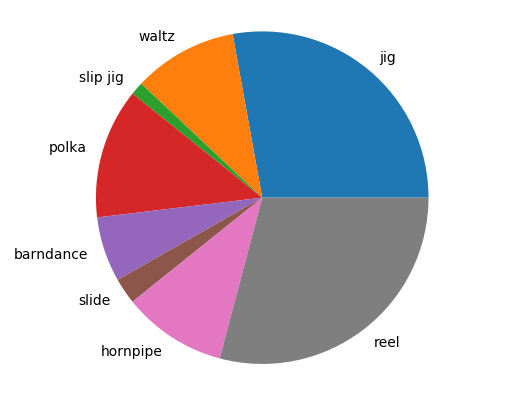

In [30]:
from collections import Counter
import matplotlib.pyplot as plt


keys = Counter(tune_types).keys() # equals to list(set(words))
vals = Counter(tune_types).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

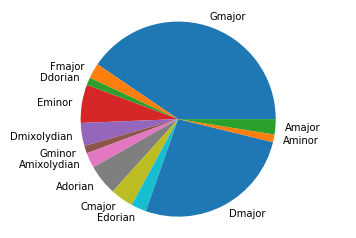

In [31]:
keys = Counter(tune_modes).keys() # equals to list(set(words))
vals = Counter(tune_modes).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal')
plt.show()

In [ ]:
# From here I am working to wrap common types of searches I need with the thesessionDB class.

In [ ]:
#import pyabc
from pyabc import *
import json
import numpy as np

import os
import sqlite3  # this is the module that binds to SQLite
import pandas as pd  # you'll see why we can use this later

from progress import progress

https://thesession.org/api

Formats
JSON	?format=json
XML	?format=xml
RSS	?format=rss
Endpoints
The following lists are available in multiple formats e.g. /tunes/new?format=json or /recordings/search?q=altan&format=rss

By default, 10 items will be returned in a list. You can request up to 50 items by appending &perpage= e.g. /tunes/new?format=json&perpage=35

If you request an individual item, e.g. /tunes/27?format=xml, you will get back the details for that item and any comments that have been posted to it.

In [ ]:
# setup database

DBFILE = 'thesession.db'  # this will be our database
BASEDIR = os.getcwd() + '/sqlite3'  # os.path.abspath(os.path.dirname(__file__))
DBPATH = os.path.join(BASEDIR, DBFILE)

# we may need to delete the existing file first
if os.path.exists(DBPATH):
    os.remove(DBPATH)

# open a connection to the database for this tutorial
conn = sqlite3.connect(DBPATH)

# get a cursor to the database
cur = conn.cursor()

In [ ]:
def get_thesession_jsons():
    import os, json
    #if not os.path.isfile("tunes.json"):
    import sys, urllib
    for f in ['tunes','recodings','aliases','events','sessions']:
        url = 'https://raw.githubusercontent.com/adactio/TheSession-data/master/json/'+f+'.json'
        print("Downloading "+f+" database from %s..." % url)
        try:
            urllib.urlretrieve(url, 'json/'+f+'.json')
        except AttributeError:
            import urllib.request
            urllib.request.urlretrieve(url, 'json/'+f+'.json')
    #return json.loads(open('tunes.json', 'rb').read().decode('utf8'))
    
#get_thesession_jsons()

In [ ]:
json_tunes = json.loads(open('json/tunes.json', 'rb').read().decode('utf8'))
json_recordings = json.loads(open('json/recordings.json', 'rb').read().decode('utf8'))
json_aliases = json.loads(open('json/aliases.json', 'rb').read().decode('utf8'))
json_events = json.loads(open('json/events.json', 'rb').read().decode('utf8'))
json_sessions = json.loads(open('json/sessions.json', 'rb').read().decode('utf8'))

In [ ]:
# unicode
print json_tunes[1]['name']

In [ ]:
n_test = 10

In [ ]:
json_tunes[41]

In [ ]:
# From tunes.json

# users 
try:
    cur.execute('DROP TABLE users')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE users (
    user TEXT PRIMARY KEY
)''')
conn.commit()

# tunes
try:
    cur.execute('DROP TABLE tunes')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE tunes (
    tune_id TEXT PRIMARY KEY,
    name TEXT NOT NULL,
    rhythm TEXT NOT NULL,
    meter TEXT NOT NULL,
    mode TEXT NOT NULL
)''')
conn.commit()

# settings
try:
    cur.execute('DROP TABLE settings')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE settings (
    setting_id TEXT PRIMARY KEY,
    tune_id TEXT NOT NULL REFERENCES tunes ON UPDATE CASCADE ON DELETE CASCADE,
    abc  TEXT,
    date TEXT NOT NULL,
    user TEXT NOT NULL REFERENCES users on UPDATE CASCADE ON DELETE CASCADE,
    name TEXT NOT NULL,
    rhythm TEXT NOT NULL,
    meter TEXT NOT NULL,
    mode TEXT NOT NULL,
    bars INTEGER,
    structure TEXT
)''')
conn.commit()

In [ ]:
# Insert entries from tunes.json
N = 1000
for i,jj in enumerate(json_tunes[:N]): 
    
    # Fill missing with None
    keys = ['setting','tune','abc','date','username','name','type','meter','mode']
    j = {}   
    for x in keys:
        try:
            j.update({x:jj[x]})
        except:
            j.update({x:None})
    
    # Check if user is new, if so add to table
    cur.execute('SELECT * FROM users WHERE (user=?)', [j['username']])
    entry = cur.fetchone()
    if entry is None:
        cur.execute('INSERT INTO users VALUES (?)', [j['username']])
        
    # Check if tune is new, if so add to table
    cur.execute('SELECT * FROM tunes WHERE (tune_id=?)', [j['tune']])
    entry = cur.fetchone()
    if entry is None:
        row = [j['tune'],j['name'],j['type'],j['meter'],j['mode']]
        cur.execute('INSERT INTO tunes VALUES (?,?,?,?,?)', row)

    row = [j['setting'],j['tune'],j['abc'],j['date'],j['username'],j['name'],j['type'],j['meter'],j['mode']]
    cur.execute('INSERT INTO settings VALUES (?,?,?,?,?,?,?,?,?,NULL,NULL)',row)
    progress(i+1,N,'Transfering tune settings from JSON to SQL.')
    
conn.commit()  # you must commit for it to become permanent


In [ ]:
cur.execute('SELECT * FROM users')
cur.fetchall()  # fetch all the results of the query

In [ ]:
cur.execute('SELECT * FROM tunes')
cur.fetchall()  # fetch all the results of the query

In [ ]:
cur.execute('SELECT setting_id, tune_id, date, user FROM settings')
cur.fetchall()  # fetch all the results of the query

In [ ]:
# from aliases.json

# Create aliases table
try:
    cur.execute('DROP TABLE aliases')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE aliases (
    alias_id INTEGER PRIMARY KEY,
    alias TEXT NOT NULL,
    name TEXT NOT NULL,
    tune_id NOT NULL REFERENCES tunes ON UPDATE CASCADE ON DELETE CASCADE
)''')
conn.commit()

In [ ]:
# insert entries from aliases.json
N = 1000
cur.execute('SELECT MAX(alias_id) from aliases')
try:
    startid = int(cur.fetchone()[0])+1
except:
    startid = 0
        
for i,j in enumerate(json_aliases[:N]):
    keys = ['alias','name','tune_id']
    jj = {}   
    for x in keys:
        try:
            jj.update({x:j[x]})
        except:
            jj.update({x:None})
    
    row = [startid+i,jj['alias'],jj['name'],jj['tune_id']]
    cur.execute('INSERT INTO aliases VALUES (?,?,?,?)',row)
    progress(i+1,N,'Transferrring aliases from JSON to SQL.')
conn.commit()

In [ ]:
cur.execute('SELECT MAX(alias_id) from aliases')
startid = int(cur.fetchone()[0])+1
startid

In [ ]:
cur.execute('SELECT * FROM aliases')
cur.fetchall()  # fetch all the results of the query

In [ ]:
# from recordings.json

#artists
try:
    cur.execute('DROP TABLE artists')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE artists (
    artist TEXT PRIMARY KEY
)''')
conn.commit()

# recordings  (albums)
try:
    cur.execute('DROP TABLE recordings')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE recordings (
    recording_id TEXT PRIMARY KEY,
    recording_name TEXT NOT NULL,
    artist TEXT REFERENCES artists ON UPDATE CASCADE ON DELETE CASCADE
)''')
conn.commit()

# recorded tunes
try:
    cur.execute('DROP TABLE recorded_tunes')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE recorded_tunes (
    id TEXT PRIMARY KEY,
    recording_id TEXT REFERENCES recordings ON UPDATE CASCADE ON DELETE CASCADE,
    recording_name TEXT NOT NULL,
    artist TEXT REFERENCES artists ON UPDATE CASCADE ON DELETE CASCADE,
    track INTEGER NOT NULL,
    number INTEGER NOT NULL,
    tune_name TEXT, 
    tune_id NOT NULL REFERENCES tunes ON UPDATE CASCADE ON DELETE CASCADE
    
)''')
conn.commit()

In [ ]:
# Insert entries from recordings.json
N = 1000
for i,j in enumerate(json_recordings[:N]): 
    
    keys = ['id','recording','artist','track','number','tune','tune_id']
    jj = {}   
    for x in keys:
        try:
            jj.update({x:j[x]})
        except:
            jj.update({x:None})
    
    # Check if user is new, if so add to table
    cur.execute('SELECT * FROM artists WHERE (artist=?)', [jj['artist']])
    entry = cur.fetchone()
    if entry is None:
        cur.execute('INSERT INTO artists VALUES (?)', [jj['artist']])
        
    # Check if tune is new, if so add to table
    cur.execute('SELECT * FROM recordings WHERE (recording_id=?)', [jj['id']])
    entry = cur.fetchone()
    if entry is None:
        row = [j['id'],j['recording'],j['artist']]
        cur.execute('INSERT INTO recordings VALUES (?,?,?)', row)

    row = [i,jj['id'],jj['recording'],jj['artist'],int(jj['track']),int(jj['number']),jj['tune'],jj['tune_id']]
    cur.execute('INSERT INTO recorded_tunes VALUES (?,?,?,?,?,?,?,?)',row)
    progress(i+1,N,'Transferring recordings from JSON to SQL.')
    
conn.commit()  # you must commit for it to become permanent
    #cur.rowcount  # tells you how many rows written, sometimes, it's quirky

In [ ]:
cur.execute('SELECT * FROM recordings')
cur.fetchall()  # fetch all the results of the query

In [ ]:
# from events.json
try:
    cur.execute('DROP TABLE events')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE events (
    event_id TEXT PRIMARY KEY,
    address TEXT,
    area TEXT,
    country TEXT,
    dtend TEXT,
    dtstart TEXT,
    event_name TEXT,
    latitude TEXT,
    logitude TEXT,
    town TEXT,
    venue TEXT
)''')
conn.commit()

In [ ]:
progress?

In [ ]:
N = 1000
for i,j in enumerate(json_events[:N]):    

    keys = ['id','address','area','country','dtend','dtstart','event','latitude','longitude','town','venue']
    row = [ None for x in range(len(keys))]
    
    for x in  range(len(keys)):
        try:
            row[x] = j[keys[x]]
        except:
            pass
    #row = [j['id'],j['address'],j['area'],j['country'],j['dtend'],j['dtstart'],j['event'],
    #      j['latitude'],j['longitude'],j['town'],j['venue']]
    cur.execute('INSERT INTO events VALUES (?,?,?,?,?,?,?,?,?,?,?)',row)
    conn.commit()  # you must commit for it to become permanent
    #cur.rowcount  # tells you how many rows written, sometimes, it's quirky
    progress(i+1,N,'Transfering events from JSON to SQL.')

In [ ]:
cur.execute('SELECT * FROM events')
cur.fetchall()  # fetch all the results of the query

In [ ]:
# from sessions.json
try:
    cur.execute('DROP TABLE sessions')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE sessions (
    session_id TEXT PRIMARY KEY,
    address TEXT,
    area TEXT,
    country TEXT,
    date TEXT,
    latitude TEXT,
    logitude TEXT,
    name TEXT,
    town TEXT
)''')
conn.commit()

In [ ]:
json_sessions[1000]

In [ ]:
N = 1000
for i,j in enumerate(json_sessions[:N]):    

    keys = ['id','address','area','country','date','latitude','longitude','name','town']
    row = [ None for x in range(len(keys))]
    
    for x in  range(len(keys)):
        try:
            row[x] = j[keys[x]]
        except:
            pass
       
    #row = [j['id'],j['address'],j['area'],j['country'],j['date'],
    #      j['latitude'],j['longitude'],j['name'],j['town']]
    
    cur.execute('INSERT INTO sessions VALUES (?,?,?,?,?,?,?,?,?)',row)
    #cur.rowcount  # tells you how many rows written, sometimes, it's quirky
    progress(i+1,N,'Transfering sessions from JSON to SQL.')
conn.commit()  # you must commit for it to become permanent

In [ ]:
cur.execute('SELECT * FROM sessions')
cur.fetchall()  # fetch all the results of the query